In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from collections import defaultdict
import shutil
from tqdm.notebook import tqdm
from wish_utils import *

In [3]:
workspaces_dir = "/home/wj1132075/Desktop/Raw_increased_range/Workspaces/"
labels_dir = "/home/wj1132075/Desktop/Raw_increased_range/Labels/"

In [4]:
annotations_output_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighboursIncreasedRange/Annotations/"
frames_output_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighboursIncreasedRange/FrameData/"

### Create Annotation files and save bin data

In [54]:
shutil.rmtree(annotations_output_dir), shutil.rmtree(frames_output_dir)
os.mkdir(annotations_output_dir), os.mkdir(frames_output_dir)

(None, None)

In [45]:
def _add_peaks(peak_data, det_y, det_x, start, peak, end):
    if det_y in peak_data:
        if (det_x, start, peak, end) in peak_data[det_y]:
            # print(f"{det_x, start, peak, end} already there for {det_y}")
            return
        peak_data[det_y].append((det_x, start, peak, end))
    else:
        peak_data[det_y] = [(det_x, start, peak, end)]
            
def save_tube_frames_with_annotations(labels, ws, annotation_outdir, frames_dir, ws_index):
    peak_data = defaultdict(list)
    for spec, peak, start, end in labels:
        det_x, det_y = find_det_coordinates(spec)
        _add_peaks(peak_data, det_y, det_x, start, peak, end)
        
        for neigh_spec, neigh_peak, neigh_start, neigh_end in labels:
            if neigh_spec == spec and peak == neigh_peak:
                continue
            neigh_x, neigh_y = find_det_coordinates(neigh_spec)
            if neigh_y in range(det_y-1, det_y+2):
                _add_peaks(peak_data, det_y, neigh_x, neigh_start, neigh_peak, neigh_end)

    frame_index = 0
    for frame, peak_list in peak_data.items():
        frame_save_path = os.path.join(frames_dir, f"{ws_index}_{frame_index}.npz")
        np.savez_compressed(frame_save_path, ws[frame,:,:])
        annotation_data = dict()
        annotation_data["nparr_path"] = frame_save_path
        annotation_data["peaks"] = peak_list
        annotation_data["tube"] = frame
        annotation_save_path = os.path.join(annotation_outdir, f"annot_{ws_index}_{frame_index}.pickle")
        with open(annotation_save_path, 'wb') as handle:
            pickle.dump(annotation_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        frame_index += 1    

In [55]:
for label_f_name in tqdm(sorted(os.listdir(labels_dir))):
    ws_index = label_f_name.split('.')[0].split('_')[-1]
    label_f_path = os.path.join(labels_dir, label_f_name)
    labels = np.loadtxt(label_f_path, delimiter=',', dtype=int)
    ws_f_name = f"workspace_{label_f_name.split('.')[0].split('_')[-1]}.npz"
    ws_f_path = os.path.join(workspaces_dir, ws_f_name)
    ws = np.load(ws_f_path)['arr_0']
    save_tube_frames_with_annotations(labels, ws, annotations_output_dir, frames_output_dir, ws_index)

  0%|          | 0/72 [00:00<?, ?it/s]

In [48]:
len(os.listdir(annotations_output_dir))

44

### Do some Analysis on data

annot_0_12.pickle


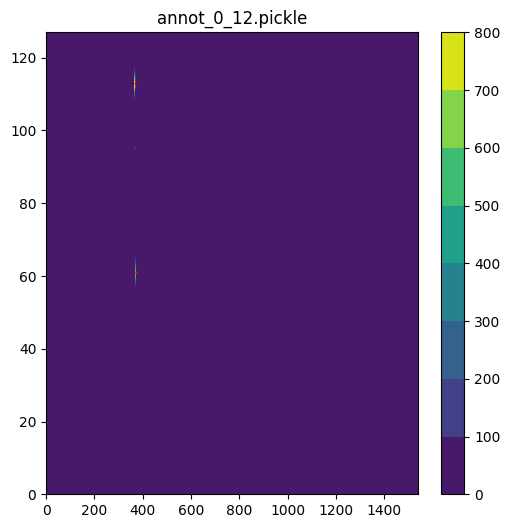

annot_0_41.pickle


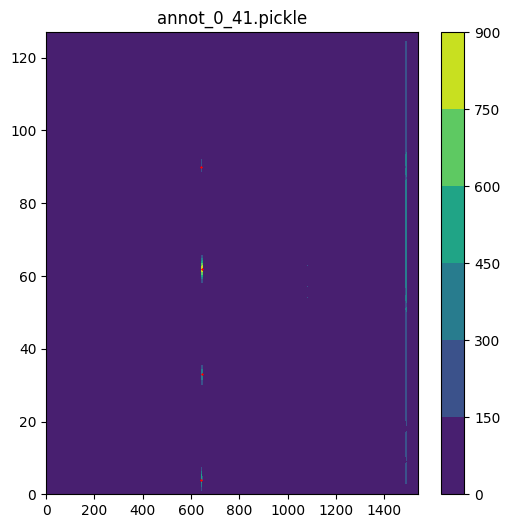

annot_0_4.pickle


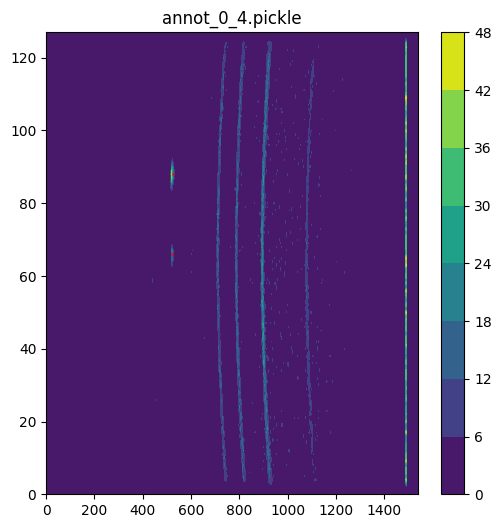

annot_0_32.pickle


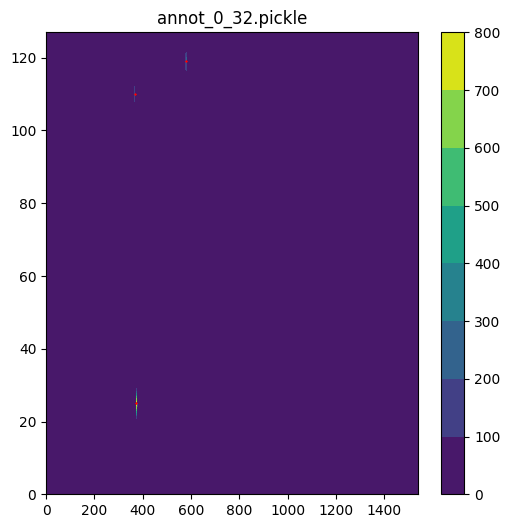

annot_0_21.pickle


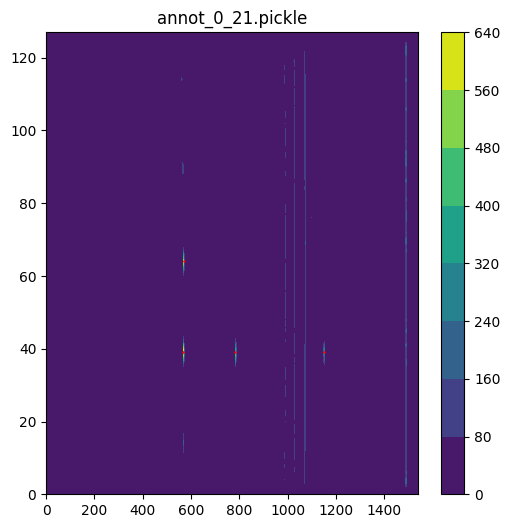

annot_0_40.pickle


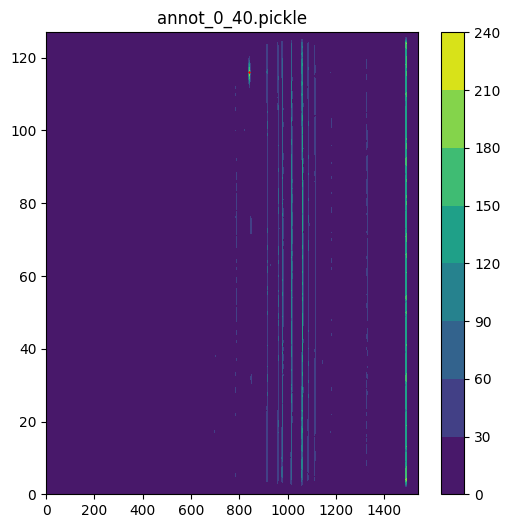

annot_0_17.pickle


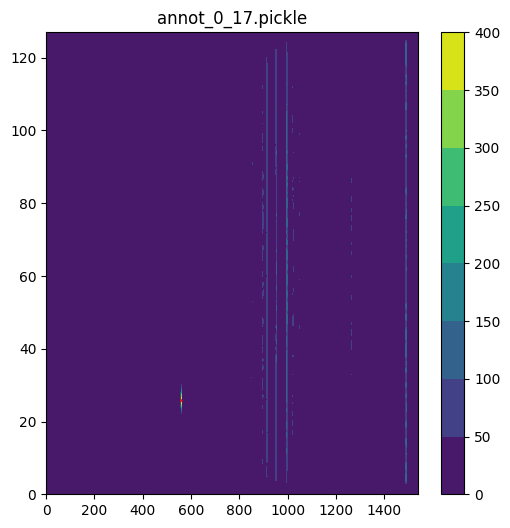

annot_0_19.pickle


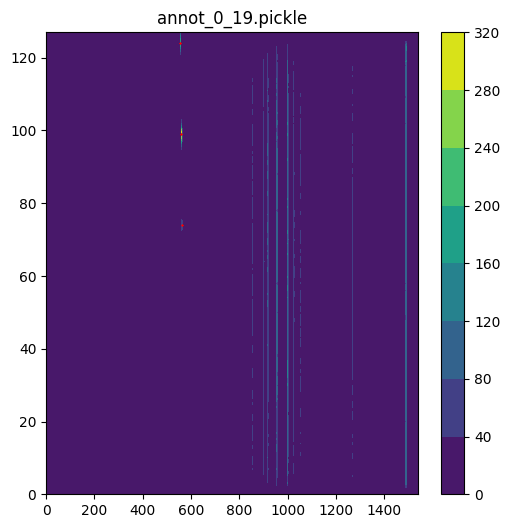

annot_0_23.pickle


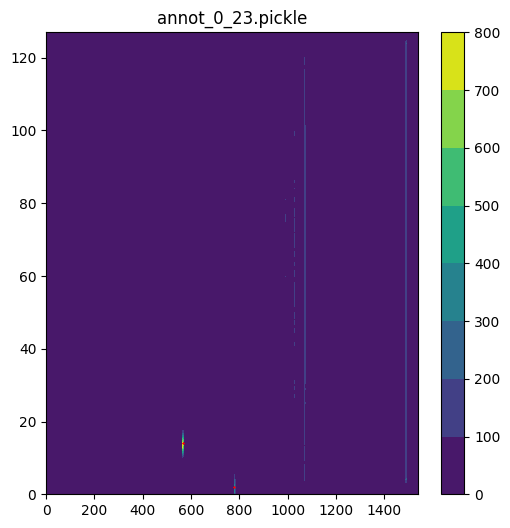

annot_0_25.pickle


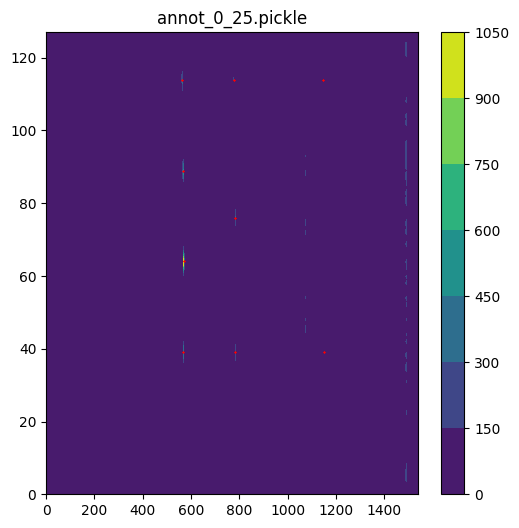

annot_0_37.pickle


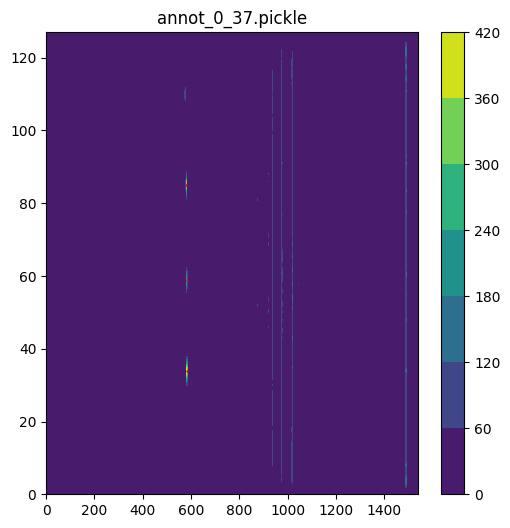

annot_0_35.pickle


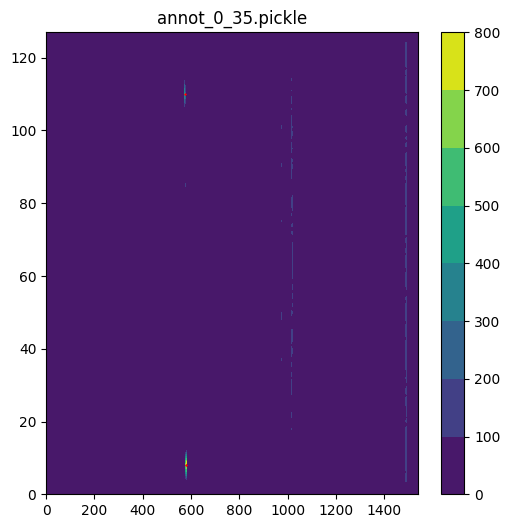

annot_0_24.pickle


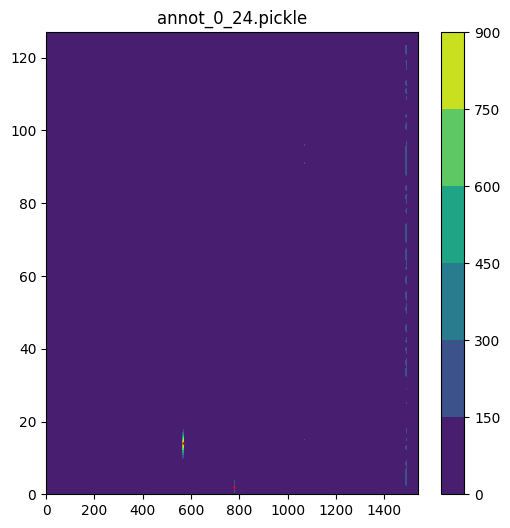

annot_0_29.pickle


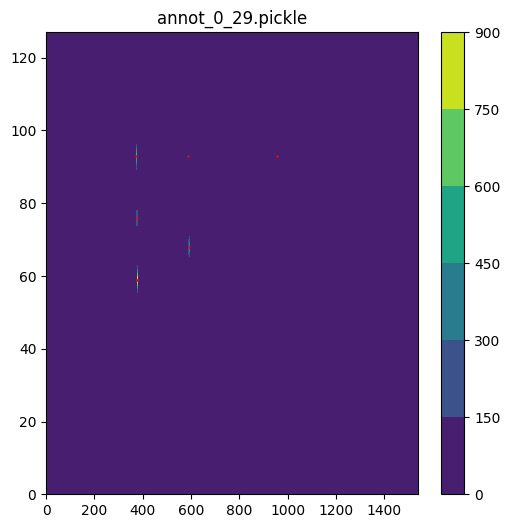

annot_0_10.pickle


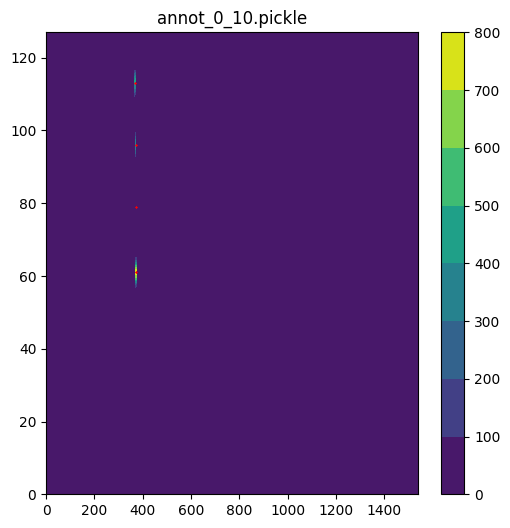

annot_0_33.pickle


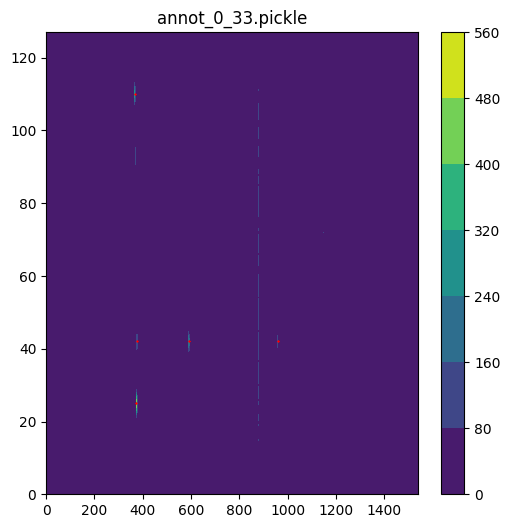

annot_0_30.pickle


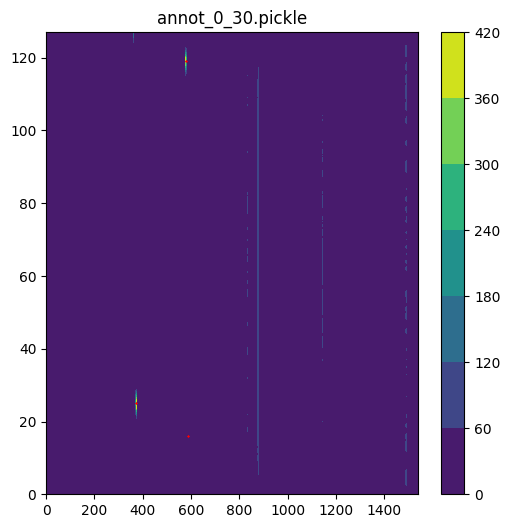

annot_0_27.pickle


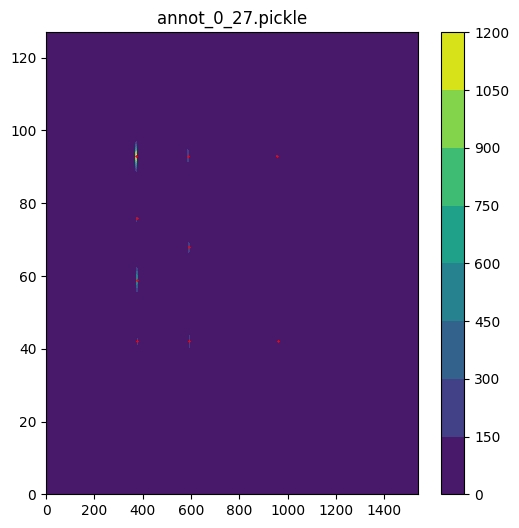

annot_0_31.pickle


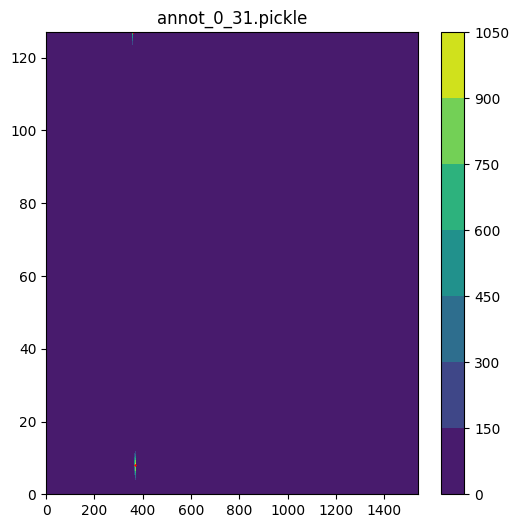

annot_0_5.pickle


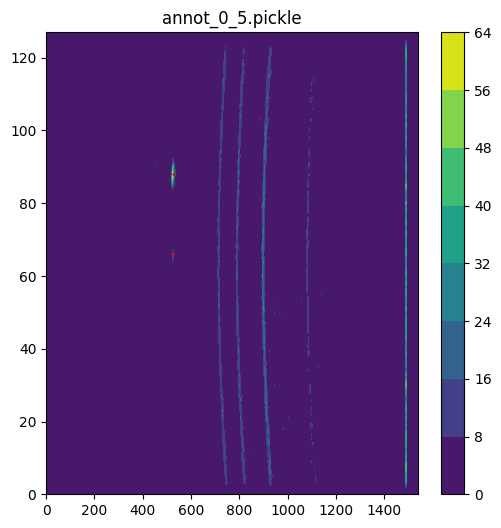

In [49]:
stop = 0
for annot_f_path in os.listdir(annotations_output_dir):
    title = annot_f_path
    annot_f_path =  os.path.join(annotations_output_dir,annot_f_path) 
    with open(annot_f_path, 'rb') as handle:
        annot_dict = pickle.load(handle)
        # print(annot_dict)
        frame_data = np.load(annot_dict['nparr_path'])['arr_0']
        # print(frame_data.shape)
        plt.figure(figsize=(6,6))
        cs = plt.contourf(frame_data)
        plt.colorbar(cs)
        print(f"{title}")
        plt.title(f"{title}")
        for x, s, p, e in annot_dict['peaks']:
            # print(f"x={p} y={x}")
            plt.plot(p, x, marker="x", markersize=1, markeredgecolor="red", markerfacecolor="red")
        plt.show()

    stop += 1
    if stop == 20:
        break

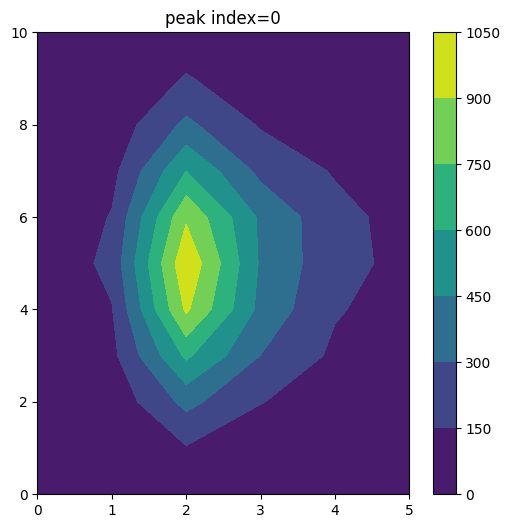

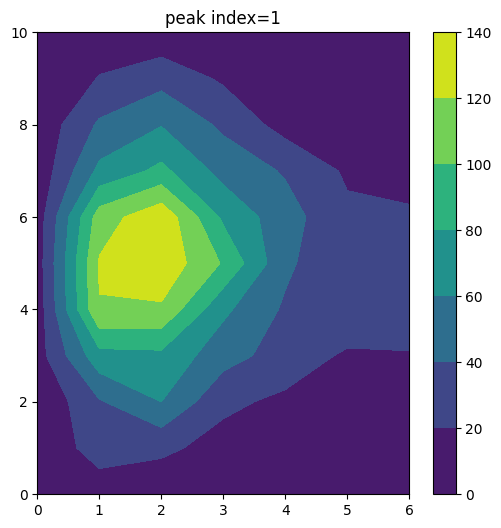

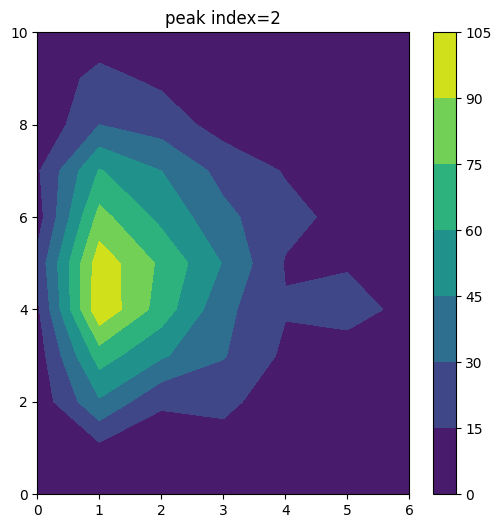

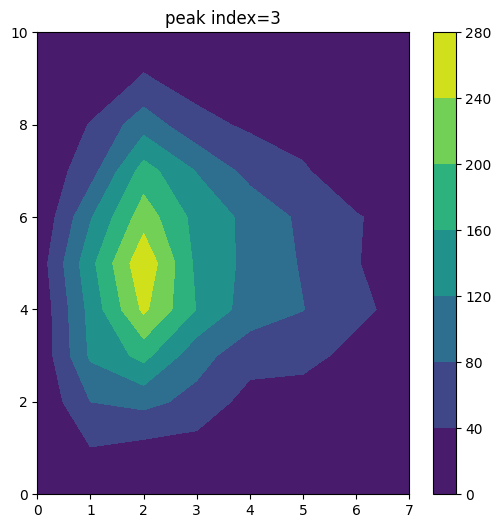

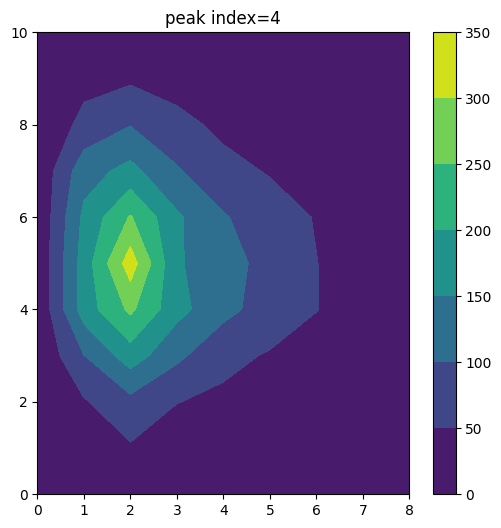

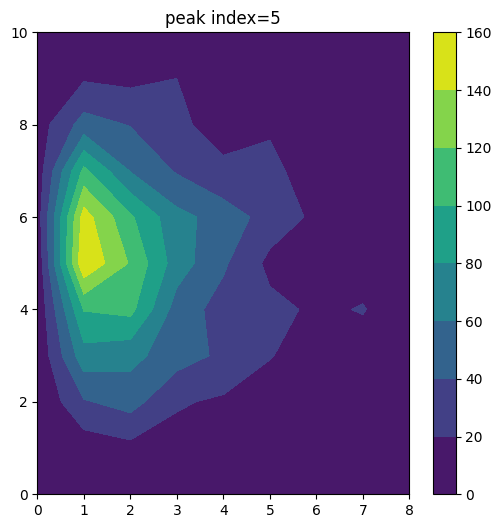

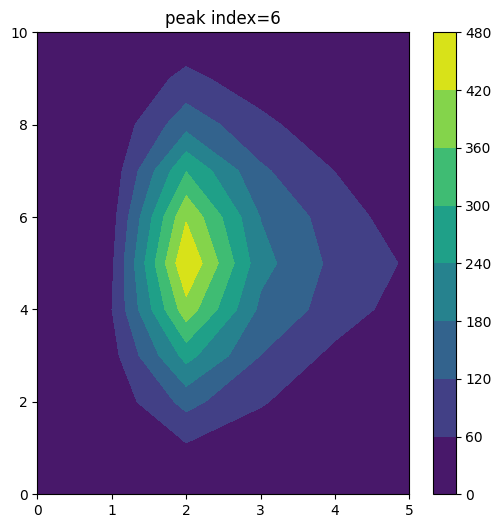

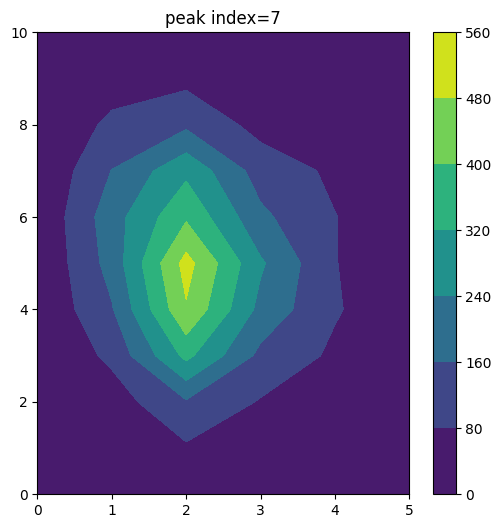

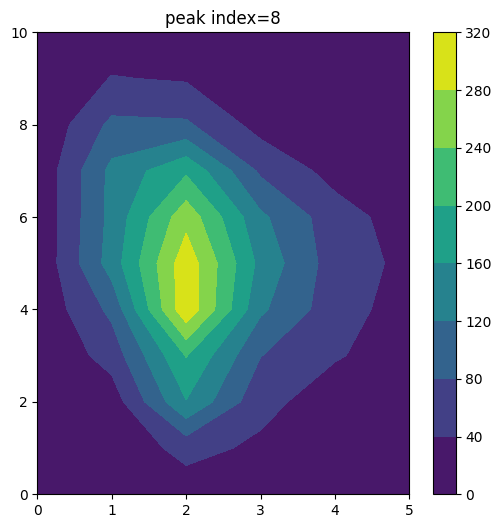

In [53]:
annot_f_path =  os.path.join(annotations_output_dir, 'annot_0_25.pickle') 
with open(annot_f_path, 'rb') as handle:
    annot_dict = pickle.load(handle)
    frame_data = np.load(annot_dict['nparr_path'])['arr_0']
peaks = annot_dict['peaks']
for p_index, peak in enumerate(peaks):
    chn_width = 5
    peak_ch = peaks[p_index][0]
    t_start = peaks[p_index][1]
    t_end = peaks[p_index][3]
    data=frame_data[peak_ch-chn_width : peak_ch+chn_width+1, t_start:t_end]
    plt.figure(figsize=(6,6))
    cs = plt.contourf(data)
    plt.colorbar(cs) 
    plt.title(f"peak index={p_index}")
    plt.show()